###Step 0: Data Preparation

Populating the interactive namespace from numpy and matplotlib


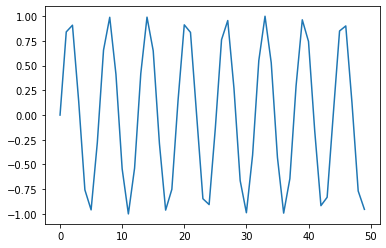

In [1]:
%pylab inline
from sklearn.metrics import mean_squared_error
import math

# menggunakan python library untuk membuat gelombang sinus seperti pada data
sin_wave = np.array([math.sin(x) for x in np.arange(200)])

#visualisasi gelombang sinus
plt.plot(sin_wave[:50])

In [2]:
#pembuatan data
X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len

for i in range(num_records - 50):
  X.append(sin_wave[i:i+seq_len])
  Y.append(sin_wave[i+seq_len])

X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

#print shape of the data
X.shape, Y.shape

# expected output
# ((100, 50, 1), (100,1))

((100, 50, 1), (100, 1))

In [3]:
X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

###Step 1: Membuat arsitektur untuk model RNN

In [4]:
learning_rate = 0.0001    
nepoch = 25               
T = 50                   # panjang sequence
hidden_dim = 100         
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

In [5]:
# mendefinisikan berat dari setiap jaringan
U = np.random.uniform(0, 1, (hidden_dim, T))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))

# U adalah matriks berat (weight matrix) untuk berat antara input dan hidden layer
# V adalah matriks berat (weight matrix) untuk berat antara hidden dan output layer
# W adalah matriks berat (weight matrix) untuk shared weight pada RNN layer (hidden layer)

In [6]:
# fungsi aktivasi sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

###Step 2: melakukan pelatihan terhadap model
####Step 2.1: cek loss pada trainin data

In [7]:
for epoch in range(nepoch):
    # check loss on train
    loss = 0.0
    #check loss on val
    val_loss = 0.0
    # do a forward pass to get prediction
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]                    # get input, output values of each record
        prev_s = np.zeros((hidden_dim, 1))   # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        for t in range(T):
            new_input = np.zeros(x.shape)    # we then do a forward pass for every timestep in the sequence
            new_input[t] = x[t]              # for this, we define a single input for that timestep
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

    for i in range(Y_val.shape[0]):
        x, y = X_val[i], Y_val[i]
        prev_s = np.zeros((hidden_dim, 1))
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

    # calculate error 
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
        loss_per_record = (y - mulv)**2 / 2
        val_loss += loss_per_record
    val_loss = val_loss / float(y.shape[0])
    loss = loss / float(y.shape[0])

    # train model
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
    
        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)
        
        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)
        
        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)
        
        # forward pass
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            layers.append({'s':s, 'prev_s':prev_s})
            prev_s = s
            
        # derivative of pred
        dmulv = (mulv - y)
        
        # backward pass
        for t in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
            dsv = np.dot(np.transpose(V), dmulv)
            
            ds = dsv
            dadd = add * (1 - add) * ds
            
            dmulw = dadd * np.ones_like(mulw)

            dprev_s = np.dot(np.transpose(W), dmulw)


            for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)

                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)

                dU_t += dU_i
                dW_t += dW_i
                
            dV += dV_t
            dU += dU_t
            dW += dW_t

            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value
                
            
            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value
        
        # update
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW
    
    print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)

Epoch:  1 , Loss:  [[62064.83348882]] , Val Loss:  [[62064.83348882]]
Epoch:  2 , Loss:  [[39654.51251908]] , Val Loss:  [[39654.51251908]]
Epoch:  3 , Loss:  [[22244.19154918]] , Val Loss:  [[22244.19154918]]
Epoch:  4 , Loss:  [[9833.86910097]] , Val Loss:  [[9833.86910097]]
Epoch:  5 , Loss:  [[2417.26224381]] , Val Loss:  [[2417.26224381]]
Epoch:  6 , Loss:  [[7.75523946]] , Val Loss:  [[7.75523946]]
Epoch:  7 , Loss:  [[8.98488959]] , Val Loss:  [[8.98488959]]
Epoch:  8 , Loss:  [[9.35046046]] , Val Loss:  [[9.35046046]]
Epoch:  9 , Loss:  [[9.22078508]] , Val Loss:  [[9.22078508]]
Epoch:  10 , Loss:  [[9.43762124]] , Val Loss:  [[9.43762124]]
Epoch:  11 , Loss:  [[9.38601]] , Val Loss:  [[9.38601]]
Epoch:  12 , Loss:  [[9.12437465]] , Val Loss:  [[9.12437465]]
Epoch:  13 , Loss:  [[9.31111309]] , Val Loss:  [[9.31111309]]
Epoch:  14 , Loss:  [[9.2851637]] , Val Loss:  [[9.2851637]]
Epoch:  15 , Loss:  [[9.22523581]] , Val Loss:  [[9.22523581]]
Epoch:  16 , Loss:  [[9.38238261]] ,

In [8]:
preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

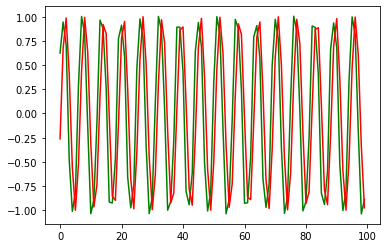

In [9]:
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()

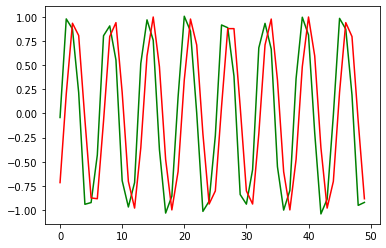

In [10]:
preds = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    # For each time step...
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error

math.sqrt(mean_squared_error(Y_val[:, 0] * max_val, preds[:, 0, 0] * max_val))

NameError: ignored